In [1]:
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence, to_categorical
import fingerprint_enhancer

In [16]:
data_dir = "./Local_Dataset"
img_size = (300, 400)
batch_size = 16 
num_classes = 4

In [19]:
# Display dataset information
def display_dataset_info(data_dir):
    class_names = os.listdir(data_dir)  # List all class directories
    class_count = {class_name: len(os.listdir(os.path.join(data_dir, class_name))) for class_name in class_names}
    
    # Print the number of images in each class
    print("Dataset Class Distribution:")
    for class_name, count in class_count.items():
        print(f"{class_name}: {count} images")
    
    # Show a sample image from each class
    plt.figure(figsize=(12, 8))
    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        sample_image_path = os.path.join(class_path, os.listdir(class_path)[0])  # Get the first image from the class
        
        # Read and resize the image
        img = cv2.imread(sample_image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = cv2.resize(img, img_size)
        
        # Display the image
        plt.subplot(2, 4, idx + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

Dataset Class Distribution:
a: 152 images
ab: 32 images
b: 208 images
o: 288 images


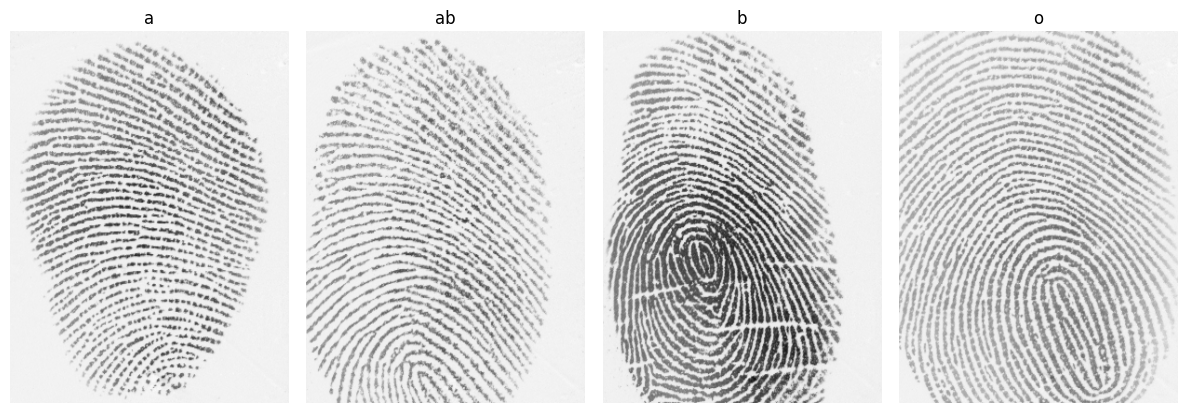

In [20]:
# Call the function to display dataset information
display_dataset_info(data_dir)

In [21]:
import cv2
import numpy as np
import random

def simple_augment(image):
    # --- Rotation ---
    angle = random.uniform(-10, 10)
    h, w = image.shape
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1)
    image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)

    # --- Brightness ---
    brightness_factor = random.uniform(0.8, 1.2)
    image = np.clip(image * brightness_factor, 0, 255)

    # --- Contrast ---
    contrast_factor = random.uniform(0.8, 1.2)
    mean = np.mean(image)
    image = np.clip((image - mean) * contrast_factor + mean, 0, 255)

    return image.astype(np.uint8)


In [22]:
def apply_masked_processing(image):
    """
    Apply Gaussian blur and adaptive thresholding to the fingerprint region.
    More conservative approach to preserve ridge patterns.
    """
    # Step 1: Create a binary mask for the fingerprint region
    # Use a more conservative threshold to preserve more detail
    _, binary_mask = cv2.threshold(image, 180, 255, cv2.THRESH_BINARY_INV)
    
    # Step 2: Apply lighter Gaussian blur to preserve ridge details
    blurred_image = cv2.GaussianBlur(image, (3, 3), 0.5)  # Reduced sigma
    
    # Step 3: Apply adaptive thresholding with adjusted parameters
    threshold_image = cv2.adaptiveThreshold(
        blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 15, 8  # Increased block size and C value
    )
    
    # Step 4: Isolate the fingerprint area (where mask is white)
    enhanced_fingerprint = cv2.bitwise_and(threshold_image, threshold_image, mask=binary_mask)
    
    # Step 5: Keep the original background (where mask is black)
    background = cv2.bitwise_and(image, image, mask=cv2.bitwise_not(binary_mask))
    
    # Step 6: Combine the enhanced fingerprint and the original background
    final_image = cv2.add(enhanced_fingerprint, background)
    
    # Ensure the result has sufficient variation
    if np.std(final_image) < 5:
        print("Warning: Masked processing resulted in low variation, returning original")
        return image
    
    return final_image

In [23]:
def preprocess_image(image_path, img_size, augment=False):
    """
    Loads, resizes, preprocesses, optionally augments, and enhances the fingerprint image.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    assert image is not None, f"Could not read image: {image_path}"
    image = cv2.resize(image, img_size)

    # Apply masked processing
    image = apply_masked_processing(image)

    # Apply manual augmentation
    if augment:
        image = simple_augment(image)

    # Check if image has sufficient variation before enhancement
    if np.std(image) < 10:  # Very low variation
        print(f"Warning: Low variation in image {image_path}, skipping enhancement")
        # Skip enhancement for problematic images
        pass
    else:
        try:
            # Fingerprint enhancement with error handling
            enhanced = fingerprint_enhancer.enhance_fingerprint(image)
            # Only use enhanced version if it's valid
            if enhanced is not None and np.std(enhanced) > 0:
                image = enhanced
            else:
                print(f"Warning: Enhancement failed for {image_path}, using original")
        except Exception as e:
            print(f"Warning: Enhancement error for {image_path}: {e}")
            # Continue with original processed image

    # Normalize and expand dims
    image = (image * 255).astype(np.uint8) if image.dtype != np.uint8 else image
    image = image / 255.0
    image = np.expand_dims(image, axis=-1)

    return image

In [24]:
class CustomImageGenerator(Sequence):
    def __init__(self, data_dir, img_size=(300, 400), batch_size=16, subset='training', validation_split=0.2, shuffle=True):
        self.data_dir = data_dir
        self.img_size = img_size
        self.batch_size = batch_size
        self.subset = subset
        self.validation_split = validation_split
        self.shuffle = shuffle
        self.class_names = sorted(os.listdir(data_dir))
        self.class_indices = {class_name: idx for idx, class_name in enumerate(self.class_names)}
        self.filepaths, self.labels = self._load_dataset()
        self.on_epoch_end()
    
    def _load_dataset(self):
        filepaths = []
        labels = []
        for class_name in self.class_names:
            class_path = os.path.join(self.data_dir, class_name)
            image_files = os.listdir(class_path)
            image_paths = [os.path.join(class_path, f) for f in image_files]
            n_total = len(image_paths)
            n_val = int(n_total * self.validation_split)
            if self.subset == 'training':
                selected = image_paths[n_val:]
            else:
                selected = image_paths[:n_val]
            filepaths.extend(selected)
            labels.extend([self.class_indices[class_name]] * len(selected))
        return filepaths, labels
    
    def __len__(self):
        return len(self.filepaths) // self.batch_size

    
    def __getitem__(self, index):
        batch_paths = self.filepaths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        
        images = [preprocess_image(path, self.img_size) for path in batch_paths]
        labels_one_hot = to_categorical(batch_labels, num_classes=len(self.class_names))
        
        return np.array(images), np.array(labels_one_hot)
    
    def on_epoch_end(self):
        if self.shuffle:
            combined = list(zip(self.filepaths, self.labels))
            random.shuffle(combined)
            self.filepaths, self.labels = zip(*combined)


In [25]:
# Instantiate training and validation generators
train_gen = CustomImageGenerator(data_dir=data_dir, img_size=img_size, batch_size=batch_size, subset='training', validation_split=0.2)
val_gen = CustomImageGenerator(data_dir=data_dir, img_size=img_size, batch_size=batch_size, subset='validation', validation_split=0.2)

In [26]:
from collections import Counter

train_counts = Counter(train_gen.labels)
valid_counts = Counter(val_gen.labels)

print("Training samples per class:")
for class_idx, count in train_counts.items():
    class_name = train_gen.class_names[class_idx]
    print(f"  {class_name}: {count}")

print("Validation samples per class:")
for class_idx, count in valid_counts.items():
    class_name = val_gen.class_names[class_idx]
    print(f"  {class_name}: {count}")


Training samples per class:
  a: 122
  b: 167
  o: 231
  ab: 26
Validation samples per class:
  o: 57
  b: 41
  a: 30
  ab: 6


In [27]:
%matplotlib

Using matplotlib backend: module://matplotlib_inline.backend_inline


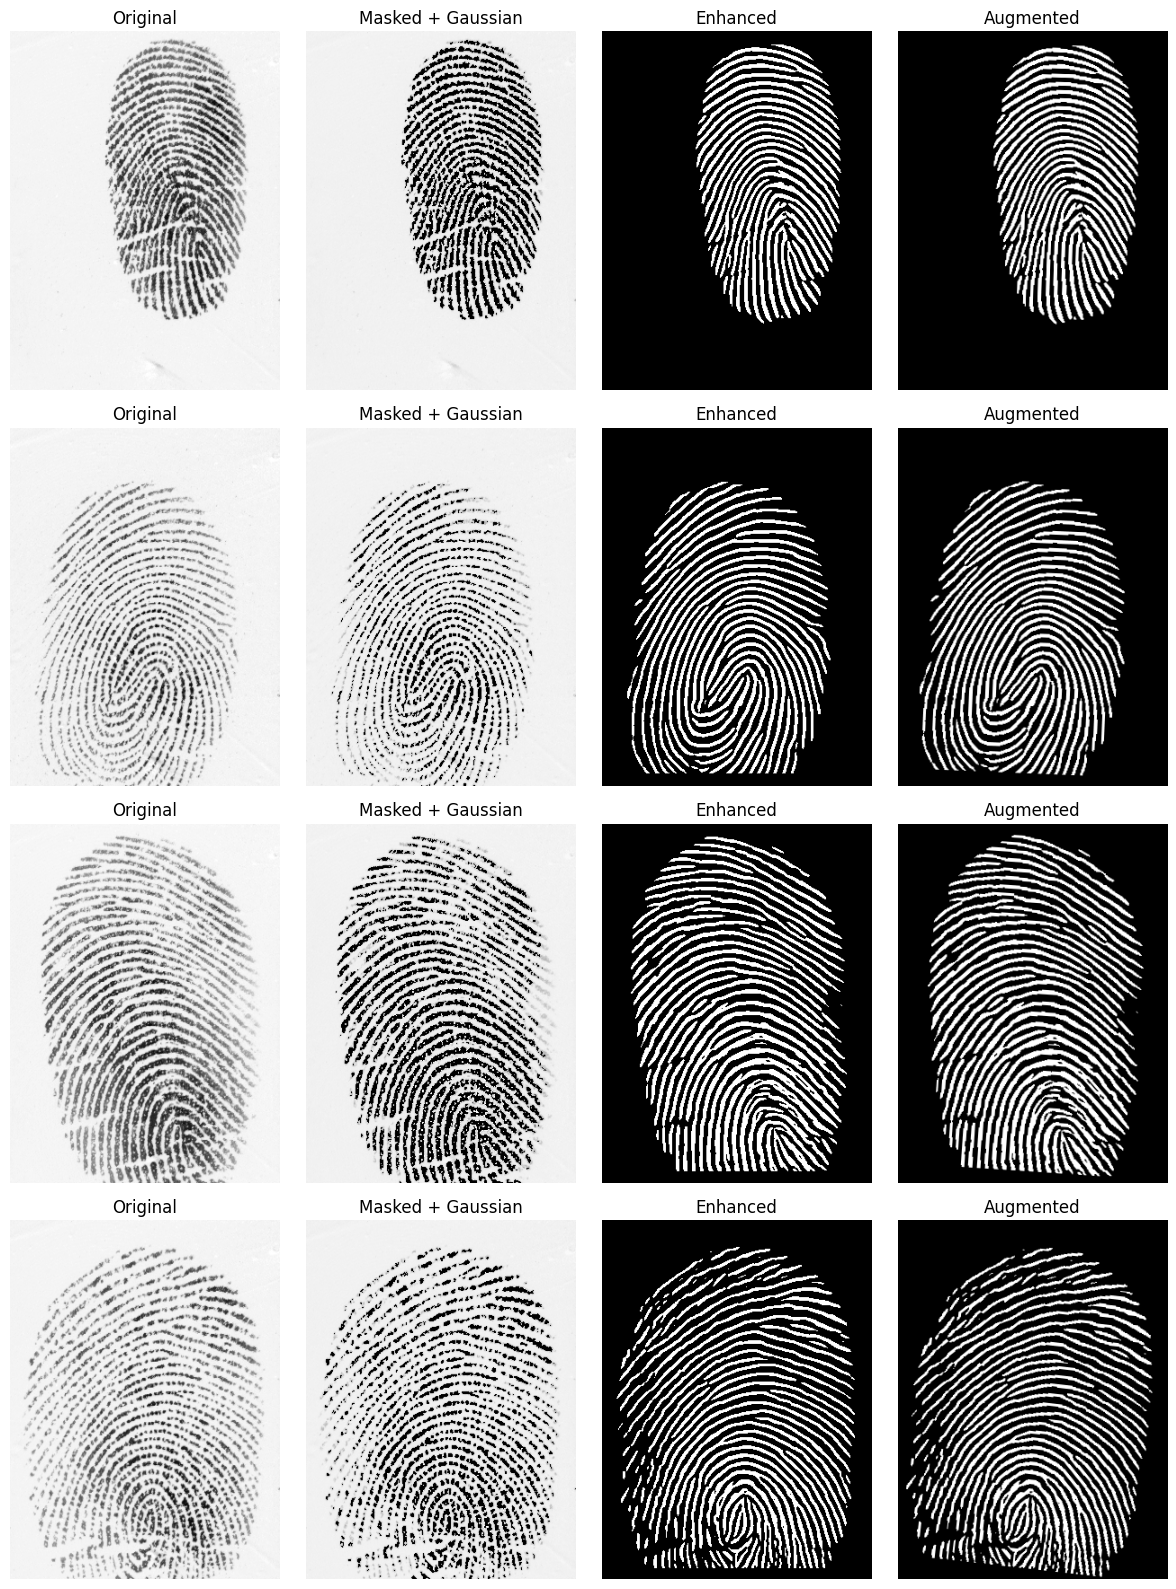

In [28]:
def visualize_samples(generator, num_samples=4):
    """
    Visualize original, processed, and enhanced images from the generator.
    """
    sample_paths = random.sample(generator.filepaths, num_samples)
    fig, axes = plt.subplots(num_samples, 4, figsize=(12, 4 * num_samples))
    
    for i, img_path in enumerate(sample_paths):
        # Load original image
        img_orig = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_orig = cv2.resize(img_orig, generator.img_size)
        
        # Apply masked processing
        img_processed = apply_masked_processing(img_orig)
        
        # Enhance fingerprint
        img_enhanced = fingerprint_enhancer.enhance_fingerprint(img_processed)
        img_enhanced = (img_enhanced * 255).astype(np.uint8)

         # Apply simple augmentation
        img_augmented = simple_augment(img_enhanced)
        
        # Plot images
        axes[i, 0].imshow(img_orig, cmap='gray')
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(img_processed, cmap='gray')
        axes[i, 1].set_title('Masked + Gaussian')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(img_enhanced, cmap='gray')
        axes[i, 2].set_title('Enhanced')
        axes[i, 2].axis('off')

        axes[i, 3].imshow(img_augmented, cmap='gray')
        axes[i, 3].set_title('Augmented')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize samples from the training generator
visualize_samples(train_gen, num_samples=4)

In [29]:
# Check the class indices mapping
print("Class Indices Mapping:", train_gen.class_indices)

Class Indices Mapping: {'a': 0, 'ab': 1, 'b': 2, 'o': 3}


In [30]:
print("Class Indices Mapping:", val_gen.class_indices)


Class Indices Mapping: {'a': 0, 'ab': 1, 'b': 2, 'o': 3}


In [31]:
from sklearn.utils import class_weight
import numpy as np

# Use train_gen.labels instead of train_gen.classes
class_labels = np.array(train_gen.labels)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)

# Optional: Map weights to class indices
class_weights_dict = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict)


Class weights: {0: 1.1188524590163935, 1: 5.25, 2: 0.8173652694610778, 3: 0.5909090909090909}


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Build a Convolutional Neural Network (CNN) Model
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(img_size[0], img_size[1], 1)),
    BatchNormalization(),  # Normalize activations after convolution
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation="relu"),
    BatchNormalization(),  # Normalizing dense layer activations
    Dropout(0.5),  # Regularization to prevent overfitting

    Dense(num_classes, activation="softmax")  # Output layer
])


c:\Users\kengu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.mean(K.sum(loss, axis=-1))
    return focal_loss_fixed

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss=focal_loss(gamma=2., alpha=0.25),
    metrics=["accuracy"]
)


In [34]:
# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 298, 398, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 298, 398, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 199, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 197, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 147, 197, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 98, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 96, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 71, 96, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 215040)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    27,525,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,619,844 (105.36 MB)

 Trainable params: 27,619,140 (105.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [35]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Callback to reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.5,          # Factor by which the learning rate will be reduced
    patience=3,          # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6          # Lower bound on the learning rate
)

In [36]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

In [37]:
steps_per_epoch = len(train_gen)
validation_steps = len(val_gen)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[reduce_lr, early_stopping],
    class_weight=class_weights_dict,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

c:\Users\kengu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1336s 39s/step - accuracy: 0.3063 - loss: 0.3913 - val_accuracy: 0.3281 - val_loss: 1.2342 - learning_rate: 5.0000e-04
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1277s 38s/step - accuracy: 0.4005 - loss: 0.2623 - val_accuracy: 0.3203 - val_loss: 2.1586 - learning_rate: 5.0000e-04
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1293s 38s/step - accuracy: 0.3900 - loss: 0.2632 - val_accuracy: 0.3047 - val_loss: 2.8018 - learning_rate: 5.0000e-04
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1248s 37s/step - accuracy: 0.5152 - loss: 0.1980 - val_accuracy: 0.3047 - val_loss: 2.8018 - learning_rate: 5.0000e-04


In [38]:
# Example for a Keras Sequence or generator
batch = next(iter(train_gen))
print("Batch type:", type(batch))
print("Batch length:", len(batch))
print("X batch shape:", batch[0].shape)
print("y batch shape:", batch[1].shape)


Batch type: <class 'tuple'>
Batch length: 2
X batch shape: (16, 400, 300, 1)
y batch shape: (16, 4)


In [39]:
batch_val = next(iter(val_gen))
print("Validation batch X shape:", batch_val[0].shape)
print("Validation batch y shape:", batch_val[1].shape)


Validation batch X shape: (16, 400, 300, 1)
Validation batch y shape: (16, 4)


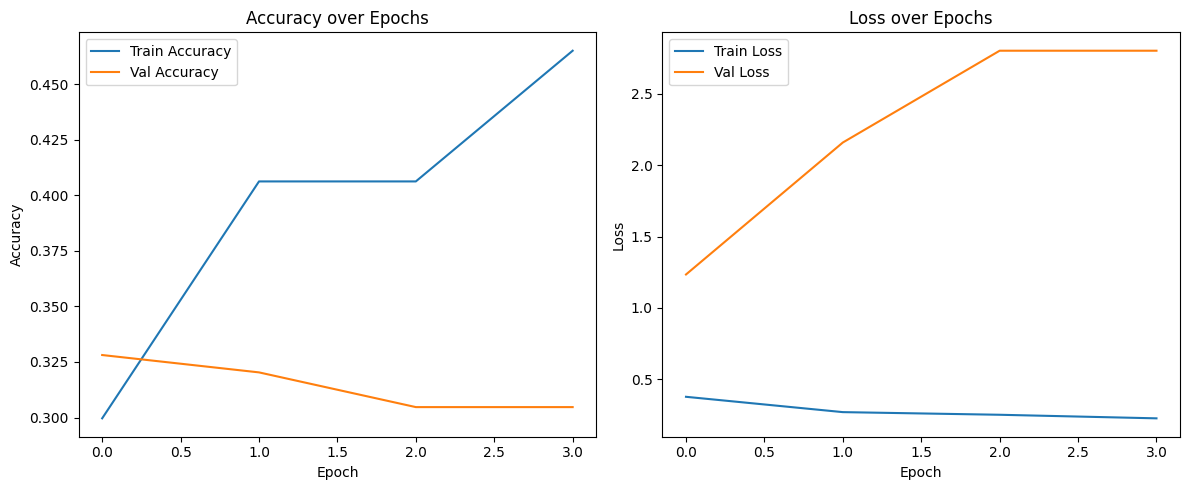

In [40]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [41]:
import numpy as np

# Get ground truth labels
y_true = []
y_pred = []

for i in range(len(val_gen)):
    X_batch, y_batch = val_gen[i]
    preds = model.predict(X_batch, verbose=0)

    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

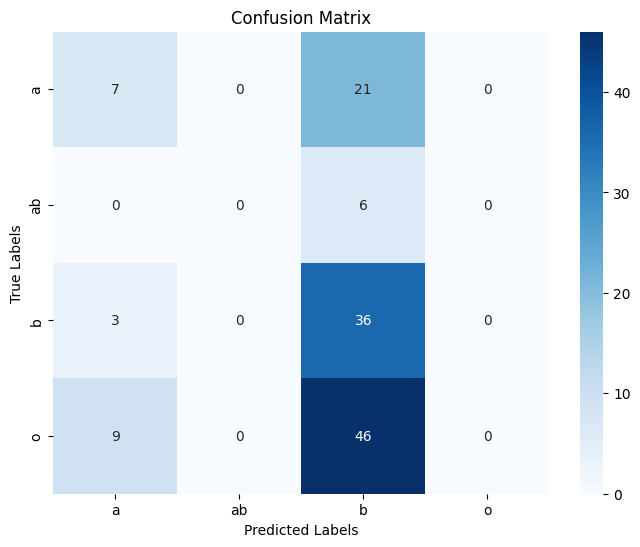

Classification Report:
              precision    recall  f1-score   support

           a       0.37      0.25      0.30        28
          ab       0.00      0.00      0.00         6
           b       0.33      0.92      0.49        39
           o       0.00      0.00      0.00        55

    accuracy                           0.34       128
   macro avg       0.17      0.29      0.20       128
weighted avg       0.18      0.34      0.21       128



c:\Users\kengu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kengu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kengu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [42]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = val_gen.class_names

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [43]:
# Save the model architecture and weights
model.save("public_fingerprint_classifier_model.h5")
print("Model saved as fingerprint_classifier_model.h5")

Model saved as fingerprint_classifier_model.h5
